<a href="https://colab.research.google.com/github/NayeraHasan/Forecasting-Models-for-Walmart-Data-Driven-Insights/blob/main/LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To try:
change data scaling.
scale date and time, scale the sales data which is not a target.

In [ ]:
!pip install kaggle
!pip install kagglehub
!pip install --upgrade scipy

In [ ]:
import kagglehub
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
import os

for file_name in os.listdir(path):
    print(file_name)

test.csv
train.csv
features.csv
stores.csv


In [ ]:
import pandas as pd

# Load each dataset
features = pd.read_csv(f"{path}/features.csv")
test = pd.read_csv(f"{path}/test.csv")
stores = pd.read_csv(f"{path}/stores.csv")
train = pd.read_csv(f"{path}/train.csv")

# Display the first few rows of each dataset to understand structure
print("Features Dataset:")
print(features.head())

print("\nTest Dataset:")
print(test.head())

print("\nStores Dataset:")
print(stores.head())

print("\nTrain Dataset:")
print(train.head())

Features Dataset:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  

Test Dataset:
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012

In [ ]:
#Change the problem to weekly sales per store, not per department per store per week
train = train.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()

print(train.head())

   Store        Date  Weekly_Sales
0      1  2010-02-05    1643690.90
1      1  2010-02-12    1641957.44
2      1  2010-02-19    1611968.17
3      1  2010-02-26    1409727.59
4      1  2010-03-05    1554806.68


In [ ]:
#Complete Dataframe
merged_data = pd.merge(train, features, on=['Store', 'Date'], how='left')
merged_data = pd.merge(merged_data, stores, on=['Store'], how='left')
merged_data = merged_data.drop(columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment' ])
# merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')

merged_data['MarkDown1'] = merged_data['MarkDown1'].fillna(0)
merged_data['MarkDown2'] = merged_data['MarkDown2'].fillna(0)
merged_data['MarkDown3'] = merged_data['MarkDown3'].fillna(0)
merged_data['MarkDown4'] = merged_data['MarkDown4'].fillna(0)
merged_data['MarkDown5'] = merged_data['MarkDown5'].fillna(0)
merged_data['IsHoliday'] = merged_data['IsHoliday'].astype(int)
print(merged_data.head())

   Store        Date  Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  \
0      1  2010-02-05    1643690.90        0.0        0.0        0.0   
1      1  2010-02-12    1641957.44        0.0        0.0        0.0   
2      1  2010-02-19    1611968.17        0.0        0.0        0.0   
3      1  2010-02-26    1409727.59        0.0        0.0        0.0   
4      1  2010-03-05    1554806.68        0.0        0.0        0.0   

   MarkDown4  MarkDown5  IsHoliday Type    Size  
0        0.0        0.0          0    A  151315  
1        0.0        0.0          1    A  151315  
2        0.0        0.0          0    A  151315  
3        0.0        0.0          0    A  151315  
4        0.0        0.0          0    A  151315  


In [ ]:
# Ensure the 'Date' column is in datetime format
for df in [merged_data]:
    df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime if not already
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
merged_data = merged_data.drop(columns="Date")

In [ ]:
del features
del train
del test
del stores

In [ ]:
#Encode Data
from sklearn.preprocessing import OneHotEncoder
import numpy as np
categorical_features = ['Type']

# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'first') # sparse=False for dense output
# Fit the encoder on the categorical features
encoder.fit(merged_data[categorical_features])
# Transform the categorical features into one-hot encoded columns
encoded_features = encoder.transform(merged_data[categorical_features])

# Create a DataFrame from the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
# Concatenate the encoded features with the original DataFrame
merged_data = pd.concat([merged_data, encoded_df], axis=1)
# Drop the original categorical columns
merged_data = merged_data.drop(categorical_features, axis=1)

In [ ]:
# Calculate the total number of NaN values in the DataFrame
total_nan_count = merged_data.isna().sum().sum()


print("Total NaN values:", total_nan_count)

Total NaN values: 0


In [ ]:
#Split the data
from sklearn.model_selection import train_test_split
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for store_id in merged_data['Store'].unique():
    #Split the data into training and testing sets
    store_df = merged_data[merged_data['Store'] == store_id].copy()
    train, test = train_test_split(store_df, test_size=0.2, random_state=42)  # Adjust test_size as needed
    # Further split train_data into train and validation sets
    train, val = train_test_split(train, test_size=0.3, random_state=42)  # Adjust test_size as needed

    #print(train.shape)
    #print(val.shape)
    #print(test.shape)
    #(79, 12)
    #(35, 12)
    #(29, 12)

    train_data = train_data._append(train)
    #print(train_data.head())
    val_data = val_data._append(val)
    test_data = test_data._append(test)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
train_data = train_data.sort_values(by=['Store', 'Year','Month','Day'])
val_data = val_data.sort_values(by=['Store', 'Year','Month','Day'])
test_data = test_data.sort_values(by=['Store', 'Year','Month','Day'])
print(train_data.head())


(3555, 14)
(1575, 14)
(1305, 14)
   Store  Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0      1    1643690.90        0.0        0.0        0.0        0.0        0.0   
1      1    1641957.44        0.0        0.0        0.0        0.0        0.0   
3      1    1409727.59        0.0        0.0        0.0        0.0        0.0   
5      1    1439541.59        0.0        0.0        0.0        0.0        0.0   
7      1    1404429.92        0.0        0.0        0.0        0.0        0.0   

   IsHoliday    Size  Year  Month  Day  Type_B  Type_C  
0          0  151315  2010      2    5     0.0     0.0  
1          1  151315  2010      2   12     0.0     0.0  
3          0  151315  2010      2   26     0.0     0.0  
5          0  151315  2010      3   12     0.0     0.0  
7          0  151315  2010      3   26     0.0     0.0  


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Scale the features
scaled_train = train_data.copy()
scaled_val = val_data.copy()
scaled_test = test_data.copy()

# Initialize separate scalers
train_sc = StandardScaler()
val_sc = StandardScaler()
test_sc = StandardScaler()

# Fit and transform the datasets with their respective scalers
scaled_train = train_sc.fit_transform(scaled_train)
scaled_val = val_sc.fit_transform(scaled_val)
scaled_test = test_sc.fit_transform(scaled_test)

# Convert scaled arrays back to DataFrames with proper column names
scaled_train = pd.DataFrame(scaled_train, columns=train_data.columns)
scaled_val = pd.DataFrame(scaled_val, columns=val_data.columns)
scaled_test = pd.DataFrame(scaled_test, columns=test_data.columns)

# Final validation
print("Scaled Train Shape:", scaled_train.shape)
print("Scaled Validation Shape:", scaled_val.shape)
print("Scaled Test Shape:", scaled_test.shape)

print(scaled_train.head())
print(scaled_val.head())
print(scaled_test.head())


Scaled Train Shape: (3555, 14)
Scaled Validation Shape: (1575, 14)
Scaled Test Shape: (1305, 14)
      Store  Weekly_Sales  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0 -1.693979      1.042087   -0.38003  -0.186023  -0.094812  -0.264958   
1 -1.693979      1.039052   -0.38003  -0.186023  -0.094812  -0.264958   
2 -1.693979      0.632414   -0.38003  -0.186023  -0.094812  -0.264958   
3 -1.693979      0.684618   -0.38003  -0.186023  -0.094812  -0.264958   
4 -1.693979      0.623137   -0.38003  -0.186023  -0.094812  -0.264958   

   MarkDown5  IsHoliday      Size     Year     Month       Day    Type_B  \
0  -0.382431  -0.335673  0.333175 -1.19576 -1.264880 -1.239444 -0.779194   
1  -0.382431   2.979094  0.333175 -1.19576 -1.264880 -0.434969 -0.779194   
2  -0.382431  -0.335673  0.333175 -1.19576 -1.264880  1.173980 -0.779194   
3  -0.382431  -0.335673  0.333175 -1.19576 -0.969242 -0.434969 -0.779194   
4  -0.382431  -0.335673  0.333175 -1.19576 -0.969242  1.173980 -0.779194   

     Ty

In [ ]:
#Create Model architecture
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dropout

dropout_rates = [.1, .15, .3]
batches = [75, 100, 120]
input_shape = [40,50,60,70]

model = Sequential()
input = model.add(Input(shape=(50, 14)))
model.add(LSTM(75, activation='tanh', dropout = .1))
#model.add(LSTM(100, activation='tanh', return_sequences=True))#per store, I will make 75 seperate sequences of 50 timestamps with 14 features per timestamp
#model.add(LSTM(100))#just more compelexity, do not use this layer
model.add(Dense(1))
#model.add(Dropout(0.2))#Add dropout within LSTM layer
model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
import numpy as np

def create_dataset(dataset, look_back, target_column='Weekly_Sales'):
    if len(dataset) <= look_back:
        raise ValueError("Dataset length must be greater than look_back.")

    input_sequences, target_values = [], []

    # Separate target and features
    targets = dataset[target_column].copy()
    features = dataset.copy()

    # Create sequences
    for i in range(len(dataset) - look_back):
        segment_start = i
        segment_end = i + look_back

        # Append feature sequences
        input_sequences.append(features.iloc[segment_start:segment_end].values)

        # Append the corresponding target value
        target_values.append(targets.iloc[segment_end])

    return np.array(input_sequences), np.array(target_values)


In [ ]:
#Validate that no data went missing or was duplicated
train_data_features, train_data_target = create_dataset(scaled_train,50)
test_data_features, test_data_target = create_dataset(scaled_test,50)
val_data_features, val_data_target = create_dataset(scaled_val,50)
print(test_data_features.shape)
print(test_data_target.shape)
print(val_data_features.shape)
print(val_data_target.shape)
print(train_data_features.shape)
print(train_data_target.shape)

(1255, 50, 14)
(1255,)
(1525, 50, 14)
(1525,)
(3505, 50, 14)
(3505,)


In [ ]:
print("Features dtype:", train_data_features.dtype)
print("Target dtype:", train_data_target.dtype)
print("Validation Features dtype:", val_data_features.dtype)
print("Validation Target dtype:", val_data_target.dtype)


Features dtype: float64
Target dtype: float64
Validation Features dtype: float64
Validation Target dtype: float64


In [ ]:
print(test_data_features[5])
print(test_data_target[5])

[[-1.69397911  0.74651901 -0.45749838 -0.16532599 -0.16256103 -0.3967854
  -0.37615138 -0.18898224  0.33317532 -1.26233749  0.07150969  0.48312378
  -0.77919372 -0.39223227]
 [-1.69397911  0.92320778 -0.45749838 -0.16532599 -0.16256103 -0.3967854
  -0.37615138 -0.18898224  0.33317532 -1.26233749  0.76277007 -0.84071146
  -0.77919372 -0.39223227]
 [-1.69397911  0.75508258 -0.45749838 -0.16532599 -0.16256103 -0.3967854
  -0.37615138 -0.18898224  0.33317532 -1.26233749  0.76277007 -0.06847424
  -0.77919372 -0.39223227]
 [-1.69397911  1.41683261 -0.45749838 -0.16532599 -0.16256103 -0.3967854
  -0.37615138 -0.18898224  0.33317532 -1.26233749  2.14529083  0.37280417
  -0.77919372 -0.39223227]
 [-1.69397911  0.42431152 -0.45749838 -0.16532599 -0.16256103 -0.3967854
  -0.37615138 -0.18898224  0.33317532  0.04508348 -1.65664125  1.5863198
  -0.77919372 -0.39223227]
 [-1.69397911  0.66616146 -0.45749838 -0.16532599 -0.16256103 -0.3967854
  -0.37615138 -0.18898224  0.33317532  0.04508348 -1.31101

In [ ]:
train_data_features = train_data_features.astype('float32')
train_data_target = train_data_target.astype('float32')
val_data_features = val_data_features.astype('float32')
val_data_target = val_data_target.astype('float32')


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
#Record how the model improves over epochs
#Run the model with 50 epochs
mae_scores = []
history = model.fit(
    train_data_features,
    train_data_target,
    epochs=50,
    validation_data=(val_data_features, val_data_target),
    verbose=2,
    shuffle=False,
    callbacks=[
        keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: mae_scores.append(logs['val_mean_absolute_error'])
        )
    ]
)
#history = model.fit(train_data_features,train_data_target, epochs=50, validation_data=(val_data_features, val_data_target), verbose=2, shuffle=False)
target_pred = model.predict(test_data_features)


Epoch 1/50
110/110 - 14s - 125ms/step - loss: 0.3869 - mean_absolute_error: 0.4269 - val_loss: 0.2802 - val_mean_absolute_error: 0.3745
Epoch 2/50
110/110 - 6s - 51ms/step - loss: 0.2383 - mean_absolute_error: 0.3299 - val_loss: 0.1783 - val_mean_absolute_error: 0.2772
Epoch 3/50
110/110 - 3s - 28ms/step - loss: 0.1895 - mean_absolute_error: 0.2738 - val_loss: 0.1518 - val_mean_absolute_error: 0.2592
Epoch 4/50
110/110 - 4s - 35ms/step - loss: 0.1918 - mean_absolute_error: 0.2750 - val_loss: 0.1479 - val_mean_absolute_error: 0.2601
Epoch 5/50
110/110 - 4s - 35ms/step - loss: 0.1559 - mean_absolute_error: 0.2495 - val_loss: 0.1453 - val_mean_absolute_error: 0.2573
Epoch 6/50
110/110 - 3s - 27ms/step - loss: 0.1545 - mean_absolute_error: 0.2498 - val_loss: 0.1411 - val_mean_absolute_error: 0.2596
Epoch 7/50
110/110 - 5s - 48ms/step - loss: 0.1550 - mean_absolute_error: 0.2485 - val_loss: 0.1362 - val_mean_absolute_error: 0.2511
Epoch 8/50
110/110 - 5s - 45ms/step - loss: 0.1462 - mean_ab

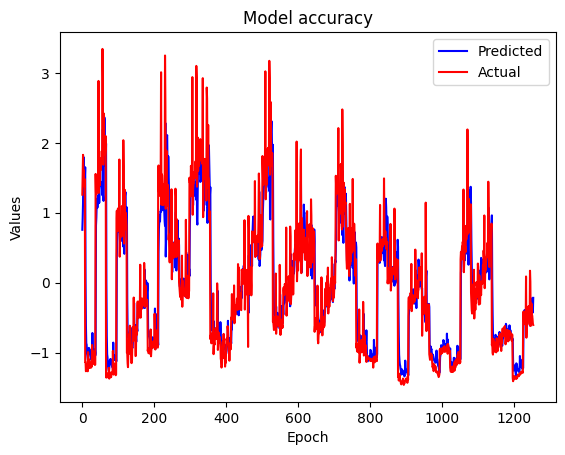

In [ ]:
import matplotlib.pyplot as plt
plt.plot(target_pred, color = "blue")
plt.plot(test_data_target, color = "red")
plt.legend(['Predicted', 'Actual'])
plt.title('Model accuracy')
plt.ylabel('Values')
plt.xlabel('Epoch')
plt.show()

My issue: I scaled my target variable

In [ ]:
print(target_pred.shape)


(1255, 1)


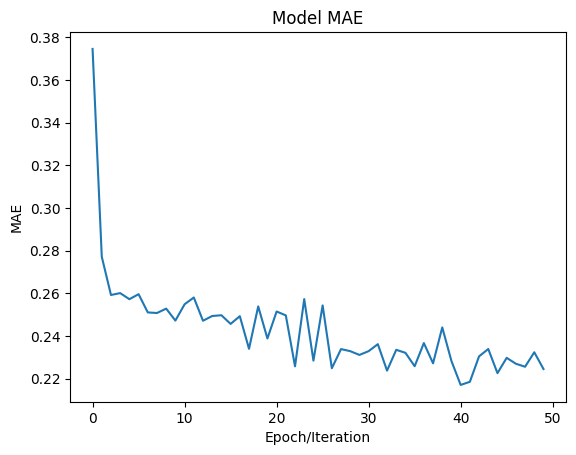

In [ ]:

import matplotlib.pyplot as plt

plt.plot(mae_scores)
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch/Iteration')  # Adjust label according to what the x-axis represents
plt.show()


In [ ]:
original_mean = train_data['Weekly_Sales'].mean()
original_std = train_data['Weekly_Sales'].std()

In [ ]:
unscaled_target_pred = (target_pred * original_std) + original_mean
unscaled_test_data_target = (test_data_target * original_std) + original_mean

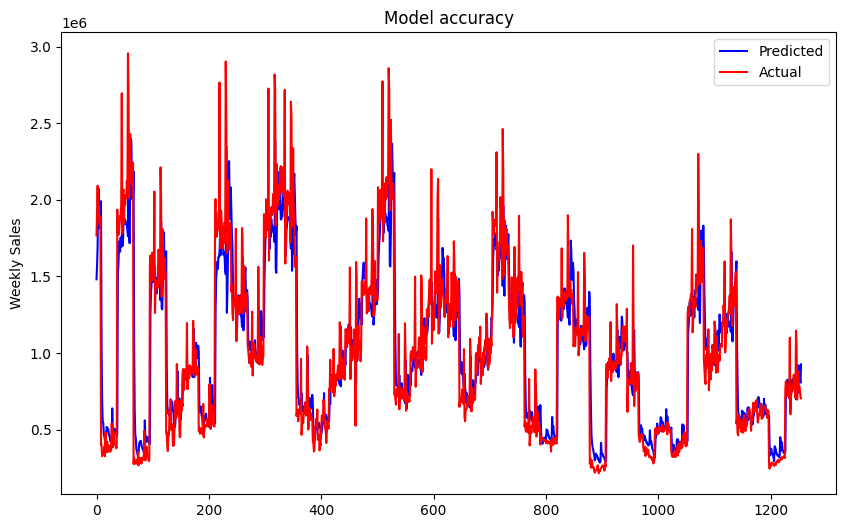

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(unscaled_target_pred, color = "blue")
plt.plot(unscaled_test_data_target, color = "red")
plt.legend(['Predicted', 'Actual'])
plt.title('Model accuracy')
plt.ylabel('Weekly Sales')
plt.show()

In [ ]:
#Performance Metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(unscaled_test_data_target, unscaled_target_pred)
r2 = r2_score(unscaled_test_data_target, unscaled_target_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 63414195499.85522
R-squared: 0.8000755895237734


In [ ]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(unscaled_test_data_target, unscaled_target_pred)
print(rmse)

251821.7534286012


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(unscaled_test_data_target, unscaled_target_pred)


target_range = unscaled_test_data_target.max() - unscaled_test_data_target.min()


nmae = mae / target_range

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Target Range: {target_range}")
print(f"Normalized Mean Absolute Error (NMAE): {nmae}")

Mean Absolute Error (MAE): 150679.5980069855
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.05493203276020888





for store, in store_dfs_train:
  features_train, target_train = create_dataset(store_dfs_train[store],12)
  features_test, target_test = create_dataset(store_dfs_test[store],12)

  ft_train_reshaped = np.reshape(features_train, (45, 132, 11))
  ft_test_reshaped = np.reshape(features_test, (45, 11, 11))

  history = model.fit(ft_train_reshaped, trgt_train_reshaped, epochs=10, validation_data=(ft_test_reshaped, trgt_test_reshaped), verbose=2, shuffle=False)


In [ ]:
"""
#optimize model, try out different parameters
dropout_rates = [.1, .15, .2, .3]
batches = [75, 100, 120]

for dropout_rate in dropout_rates:
  for batch_size in batches:
      model = Sequential()
      input = model.add(Input(shape=(50, 14)))
      model.add(LSTM(batch_size, activation='tanh', dropout = dropout_rate))
      #model.add(LSTM(100, activation='tanh', return_sequences=True))#per store, I will make 77 seperate sequences of 13 timestamps with 11 features per timestamp
      #model.add(LSTM(100))
      model.add(Dense(1))
      #model.add(Dropout(0.2))
      model.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

      mae_scores = []
      history = model.fit(
          train_data_features,
          train_data_target,
          epochs=50,
          validation_data=(val_data_features, val_data_target),
          verbose=2,
          shuffle=False,
          callbacks=[
              keras.callbacks.LambdaCallback(
                  on_epoch_end=lambda epoch, logs: mae_scores.append(logs['val_mean_absolute_error'])
              )
          ]
      )
      #history = model.fit(train_data_features,train_data_target, epochs=50, validation_data=(val_data_features, val_data_target), verbose=2, shuffle=False)
      target_pred = model.predict(test_data_features)
      original_mean = train_data['Weekly_Sales'].mean()
      original_std = train_data['Weekly_Sales'].std()
      unscaled_target_pred = (target_pred * original_std) + original_mean
      unscaled_test_data_target = (test_data_target * original_std) + original_mean


      mse = mean_squared_error(unscaled_test_data_target, unscaled_target_pred)
      r2 = r2_score(unscaled_test_data_target, unscaled_target_pred)

      print(f"Mean Squared Error: {mse}")
      print(f"R-squared: {r2}")
      mae = mean_absolute_error(unscaled_test_data_target, unscaled_target_pred)

      # Calculate target range
      target_range = unscaled_test_data_target.max() - unscaled_test_data_target.min()

      # Calculate NMAE
      nmae = mae / target_range

      print(f"Mean Absolute Error (MAE): {mae}")
      print(f"Target Range: {target_range}")
      print(f"Normalized Mean Absolute Error (NMAE): {nmae}")
      print(f"Dropout Rate  {dropout_rate}")
      print(f"batch size  {batch_size}")
      print("\n\n")
"""

'\n#optimize model\ndropout_rates = [.1, .15, .2, .3]\nbatches = [75, 100, 120]\n\nfor dropout_rate in dropout_rates:\n  for batch_size in batches:\n      model = Sequential()\n      input = model.add(Input(shape=(50, 14)))\n      model.add(LSTM(batch_size, activation=\'tanh\', dropout = dropout_rate))\n      #model.add(LSTM(100, activation=\'tanh\', return_sequences=True))#per store, I will make 77 seperate sequences of 13 timestamps with 11 features per timestamp\n      #model.add(LSTM(100))\n      model.add(Dense(1))\n      #model.add(Dropout(0.2))\n      model.compile(optimizer = \'adam\', loss=\'mean_squared_error\', metrics=[\'mean_absolute_error\'])\n\n      mae_scores = []\n      history = model.fit(\n          train_data_features,\n          train_data_target,\n          epochs=50,\n          validation_data=(val_data_features, val_data_target),\n          verbose=2,\n          shuffle=False,\n          callbacks=[\n              keras.callbacks.LambdaCallback(\n              

sources
https://www.kaggle.com/code/shivajbd/input-and-output-shape-in-lstm-keras

Mean Squared Error: 56249523165.49697
R-squared: 0.8226634798440909
Mean Absolute Error (MAE): 144669.53636264164
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.052740993578363794
Dropout Rate  0.1
batch size  75

Mean Squared Error: 61210237102.57868
R-squared: 0.8070239562075492
Mean Absolute Error (MAE): 149907.50067894292
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.054650555531180575
Dropout Rate  0.1
batch size  100

Mean Squared Error: 64597434915.509186
R-squared: 0.7963452190481692
Mean Absolute Error (MAE): 154618.08801591306
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.056367855957627645
Dropout Rate  0.1
batch size  120

Mean Squared Error: 63024123631.134384
R-squared: 0.8013053597318895
Mean Absolute Error (MAE): 164953.22401573326
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.060135652240818
Dropout Rate  0.15
batch size  75

Mean Squared Error: 65563346607.63483
R-squared: 0.7933000124647197
Mean Absolute Error (MAE): 163226.44161409908
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.05950613325675539
Dropout Rate  0.15
batch size  100

Mean Squared Error: 62926191695.33662
R-squared: 0.8016141073928326
Mean Absolute Error (MAE): 162053.12401027765
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.059078386422387934
Dropout Rate  0.15
batch size  120

Mean Squared Error: 67612220589.432175
R-squared: 0.7868405766913549
Mean Absolute Error (MAE): 173215.9907640191
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.06314794175917576
Dropout Rate  0.2
batch size  75

Mean Squared Error: 61916364260.84696
R-squared: 0.8047977660820534
Mean Absolute Error (MAE): 157505.48063091387
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.057420489146305626
Dropout Rate  0.2
batch size  100

Mean Squared Error: 62534064303.05929
R-squared: 0.8028503580006765
Mean Absolute Error (MAE): 164653.48742564805
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.060026379715514146
Dropout Rate  0.2
batch size  120

Mean Squared Error: 70821425106.05257
R-squared: 0.7767229947205414
Mean Absolute Error (MAE): 187360.86672178665
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.06830462388322255
Dropout Rate  0.3
batch size  75

Mean Squared Error: 71007220189.28703
R-squared: 0.7761372430257949
Mean Absolute Error (MAE): 186514.67144526477
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.06799613336913664
Dropout Rate  0.3
batch size  100

Mean Squared Error: 75199011286.91582
R-squared: 0.7629218839500049
Mean Absolute Error (MAE): 197250.1328798184
Target Range: 2743018.7895055157
Normalized Mean Absolute Error (NMAE): 0.07190987303276064
Dropout Rate  0.3
batch size  120